In [1]:
# !pip uninstall virny -y

In [2]:
# Install using an HTTP link
# !pip install git+https://github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

# Install using an SSH link
# !pip install git+ssh://git@github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

from virny.datasets import ACSIncomeDataset
from virny.utils.model_tuning_utils import tune_ML_models
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from virny.utils.data_viz_utils import create_dataset_stats_bar_chart
from virny.utils.custom_initializers import create_models_config_from_tuned_params_df

from pprint import pprint
from datetime import datetime, timezone
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from EDA_utils import get_correlation_with_target, get_correlation_matrix, get_features_by_target_correlation_threshold

## Load dataset

In [6]:
DATASET_SPLIT_SEED = 42
MODELS_TUNING_SEED = 42
TEST_SET_FRACTION = 0.2
DATASET_NAME = 'ACS_Income_GA_2018'

sensitive_attributes_dct = {'SEX': '2', 'RAC1P': ['2', '3', '4', '5', '6', '7', '8', '9'], 'SEX & RAC1P': None}
sensitive_attributes = [attr for attr in sensitive_attributes_dct.keys() if '&' not in attr]

In [7]:
data_loader = ACSIncomeDataset(state=['GA'], year=2018, with_nulls=False,
                               subsample_size=15_000, subsample_seed=42)
data_loader.full_df.head()

,SCHL,COW,MAR,OCCP,POBP,RELP,SEX,RAC1P,AGEP,WKHP,PINCP
0,23,7,3,230,36,0,1,1,55,55.0,1
1,16,1,5,4110,13,2,2,1,20,35.0,0
2,16,4,3,4130,51,0,2,1,59,30.0,0
3,18,4,1,4020,13,0,1,2,43,40.0,0
4,14,1,1,8300,20,1,2,2,33,20.0,0


In [8]:
data_loader.target

'PINCP'

In [9]:
data_loader.full_df.shape

(15000, 11)

In [10]:
data_loader.full_df.isnull().sum()

SCHL     0
COW      0
MAR      0
OCCP     0
POBP     0
RELP     0
SEX      0
RAC1P    0
AGEP     0
WKHP     0
PINCP    0
dtype: int64

## Check proportions and base rates

In [11]:
create_dataset_stats_bar_chart(data_loader.X_data, data_loader.y_data, sensitive_attributes_dct)

alt.FacetChart(...)

### Data Profiling

In [12]:
for col in data_loader.categorical_columns:
    print(f'{col}: {len(data_loader.full_df[col].unique())}')

SCHL: 24
COW: 8
MAR: 5
OCCP: 500
POBP: 188
RELP: 18
SEX: 2
RAC1P: 8


In [13]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), data_loader.categorical_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
column_transformer = column_transformer.set_output(transform="pandas")  # Set transformer output to a pandas df

In [14]:
full_processed_df = column_transformer.fit_transform(data_loader.full_df)
list(full_processed_df.columns)

['SCHL_1',
 'SCHL_10',
 'SCHL_11',
 'SCHL_12',
 'SCHL_13',
 'SCHL_14',
 'SCHL_15',
 'SCHL_16',
 'SCHL_17',
 'SCHL_18',
 'SCHL_19',
 'SCHL_2',
 'SCHL_20',
 'SCHL_21',
 'SCHL_22',
 'SCHL_23',
 'SCHL_24',
 'SCHL_3',
 'SCHL_4',
 'SCHL_5',
 'SCHL_6',
 'SCHL_7',
 'SCHL_8',
 'SCHL_9',
 'COW_1',
 'COW_2',
 'COW_3',
 'COW_4',
 'COW_5',
 'COW_6',
 'COW_7',
 'COW_8',
 'MAR_1',
 'MAR_2',
 'MAR_3',
 'MAR_4',
 'MAR_5',
 'OCCP_10',
 'OCCP_1005',
 'OCCP_1006',
 'OCCP_1007',
 'OCCP_101',
 'OCCP_1010',
 'OCCP_102',
 'OCCP_1021',
 'OCCP_1022',
 'OCCP_1031',
 'OCCP_1032',
 'OCCP_1050',
 'OCCP_1065',
 'OCCP_110',
 'OCCP_1105',
 'OCCP_1106',
 'OCCP_1108',
 'OCCP_120',
 'OCCP_1200',
 'OCCP_1220',
 'OCCP_1240',
 'OCCP_1305',
 'OCCP_1306',
 'OCCP_1310',
 'OCCP_1320',
 'OCCP_135',
 'OCCP_1350',
 'OCCP_136',
 'OCCP_1360',
 'OCCP_137',
 'OCCP_140',
 'OCCP_1400',
 'OCCP_1410',
 'OCCP_1420',
 'OCCP_1430',
 'OCCP_1450',
 'OCCP_1460',
 'OCCP_150',
 'OCCP_1520',
 'OCCP_1530',
 'OCCP_1541',
 'OCCP_1545',
 'OCCP_1551',


### Correlation of sensitive attributes with the target

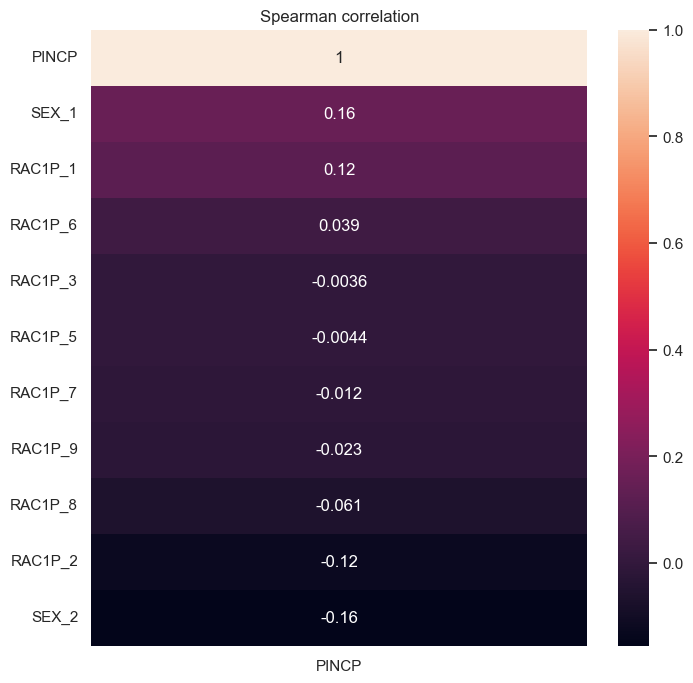

In [15]:
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=[col for col in full_processed_df.columns \
                                           if col != data_loader.target \
                                           and (col.startswith(sensitive_attributes[0]) or col.startswith(sensitive_attributes[1]))
                                           ],
                            heatmap_size=(8, 8))

### Correlation of selected attributes with the target

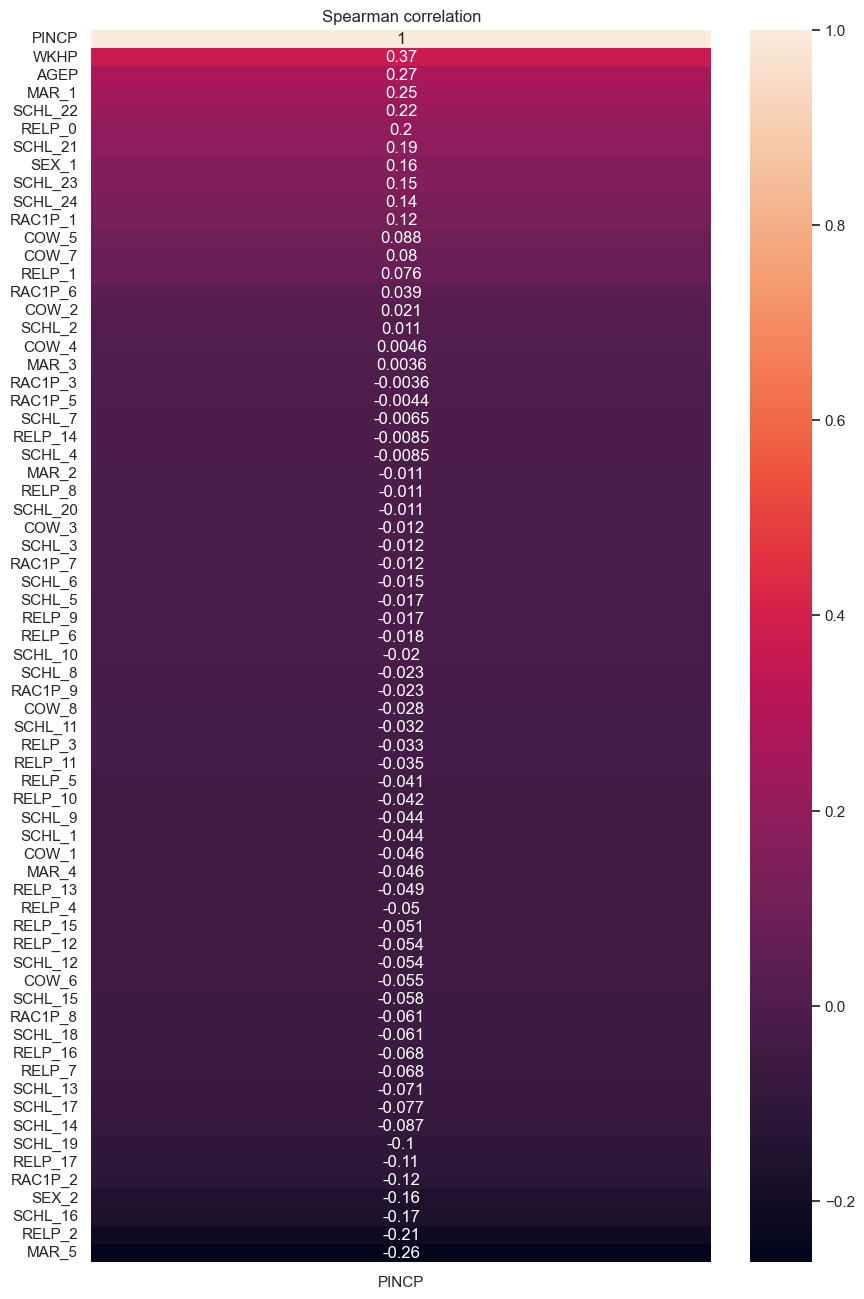

In [27]:
filtered_feature_names = [col for col in full_processed_df.columns \
                          if col != data_loader.target \
                           and not col.startswith('OCCP') \
                           and not col.startswith('POBP')]
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=filtered_feature_names,
                            heatmap_size=(16, 10))

### Correlation matrix for features which have high correlation with the target

In [17]:
high_correlated_features = get_features_by_target_correlation_threshold(
    df=full_processed_df[filtered_feature_names + [data_loader.target]],
    target=data_loader.target,
    threshold=0.1
)
high_correlated_features

['SCHL_16',
 'SCHL_19',
 'SCHL_21',
 'SCHL_22',
 'SCHL_23',
 'SCHL_24',
 'MAR_1',
 'MAR_5',
 'RELP_0',
 'RELP_17',
 'RELP_2',
 'SEX_1',
 'SEX_2',
 'RAC1P_1',
 'RAC1P_2',
 'AGEP',
 'WKHP']

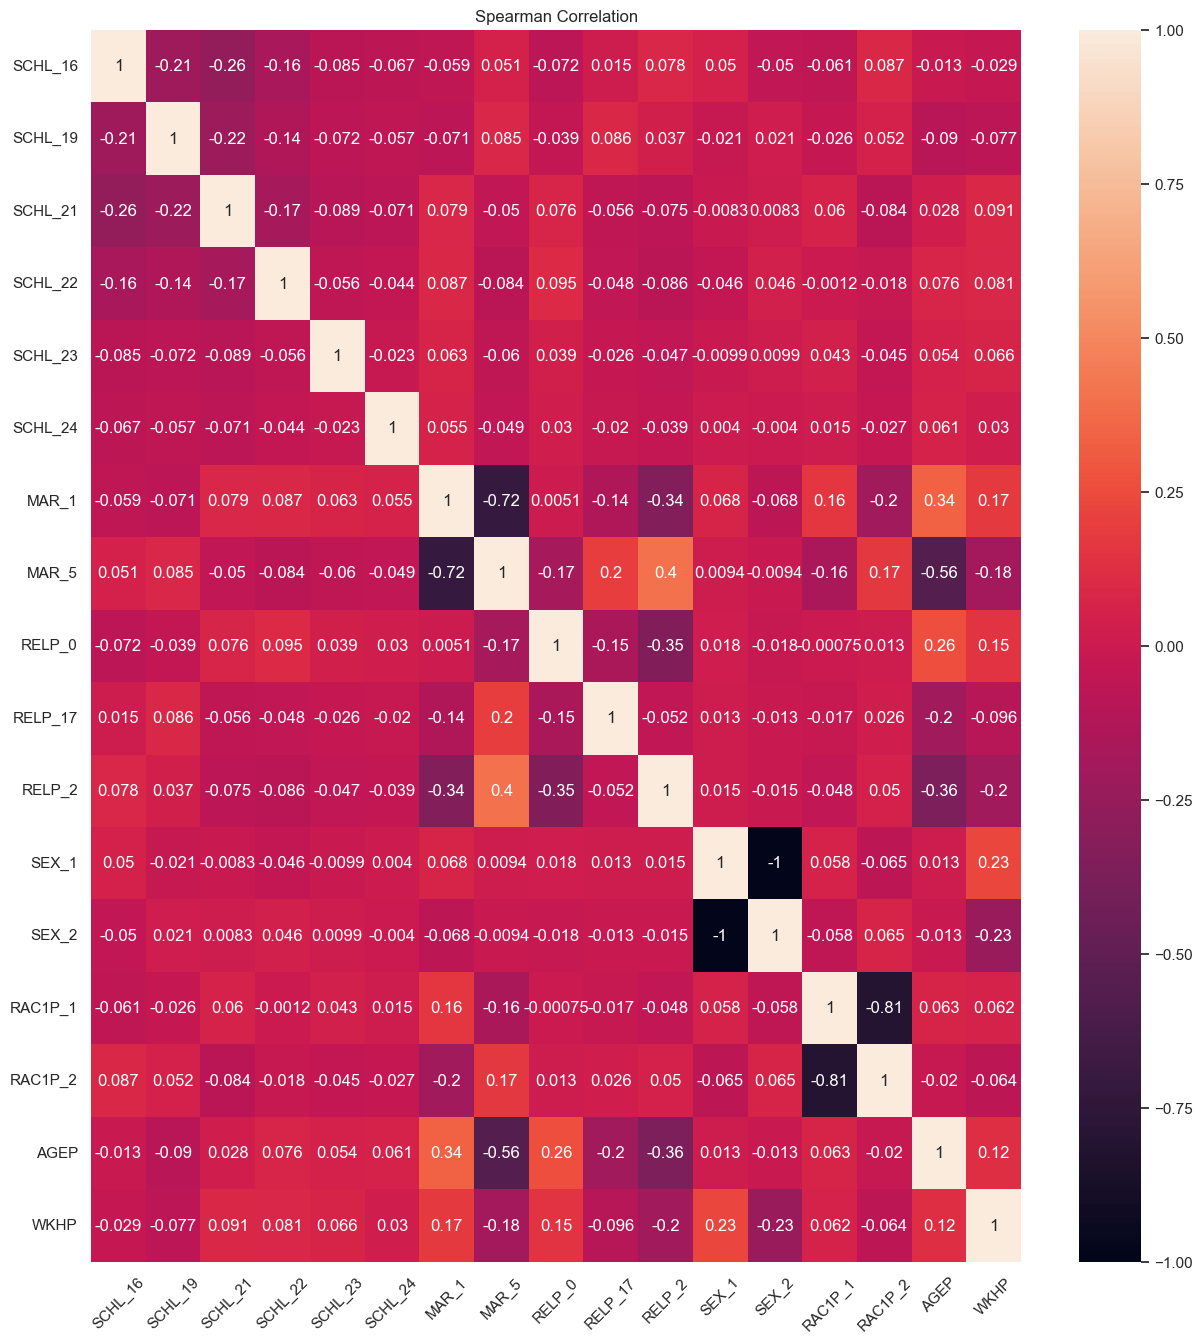

In [18]:
get_correlation_matrix(df=full_processed_df,
                       feature_names=high_correlated_features)

## Data preparation

In [19]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), data_loader.categorical_columns),
        ('num', StandardScaler(), data_loader.numerical_columns),
    ],
    verbose_feature_names_out=False
)

In [20]:
base_flow_dataset = preprocess_dataset(data_loader, column_transformer, TEST_SET_FRACTION, DATASET_SPLIT_SEED)

## Tune RandomForest

In [21]:
models_params_for_tuning = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=MODELS_TUNING_SEED),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
}

In [22]:
# tuned_params_df, models_config = tune_ML_models(models_params_for_tuning, base_flow_dataset, DATASET_NAME, n_folds=3)
# tuned_params_df

In [23]:
# now = datetime.now(timezone.utc)
# date_time_str = now.strftime("%Y%m%d__%H%M%S")
# tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
# tuned_params_df.to_csv(tuned_df_path, sep=",", columns=tuned_params_df.columns, float_format="%.4f", index=False)

## Analyze Feature Importance With Scikit-Learn

In [24]:
tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
models_config = create_models_config_from_tuned_params_df(models_params_for_tuning, tuned_df_path)
pprint(models_config)

{'RandomForestClassifier': RandomForestClassifier(max_depth=80, min_samples_split=10, n_estimators=500,
                       random_state=42)}


In [25]:
rf = models_config['RandomForestClassifier']
rf = rf.fit(base_flow_dataset.X_train_val, base_flow_dataset.y_train_val)

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

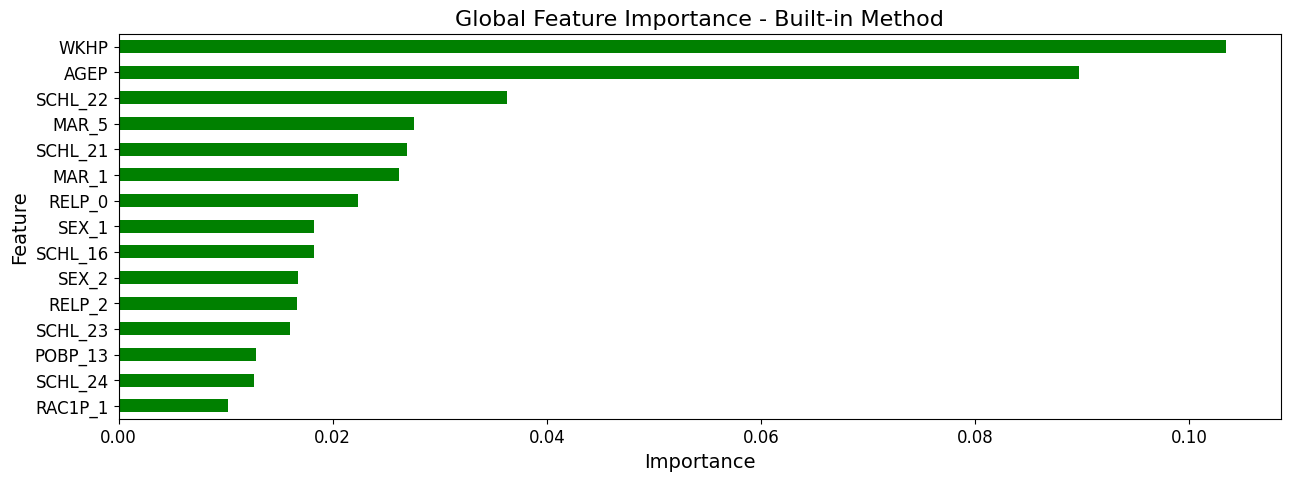

In [26]:
global_importances = pd.Series(rf.feature_importances_, index=base_flow_dataset.X_train_val.columns)
global_importances = global_importances[global_importances > 0.01]
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')

plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Global Feature Importance - Built-in Method", fontsize=16)